NOTE: CoLab usually autosaves your work, but just to be safe, make sure to save it manually too!


***Double click*** and enter your name here!

Name: Qianwen Luo

# Lab 8: Iterative Prisoner's Dilemma with Evolutionary Strategy
Lab 8 will focus on a classic agent-based model in the field of game theory: the Evolutionary Iterative Prisoner's Dilemma. This is one of many game theory models of evolution, in which you'll practice implementing a very simple learning strategy.

The goal of creating and running experiments on this model will be to figure out what conditions cause the emergence of cooperation, and what conditions cause the emergence of defection over time.

Problem 1 is a basic coding exercise. Problems 2 through 4 focus on creating and experimenting on the Iterative Prisoner's Dilemma model. Problem 5 is conceptual, however answering it requires successful completion of problems 2 through 4.

## Basic Coding Exercises
### Problem 1: Can You Take Me High-er? (3 points)
In this problem, you'll practice a commonly-used strategy in many computer algorithms: finding the largest value in a list. Here's how the algorithm works:


1.   Make an empty list to store the largest values. Your algorithm will fill this up later.
2.   Make a variable that keeps track of what the current highest number is as your algorithm looks through the list.
3.   Iterate through the list of numbers that you want to find the maximum of, and do the following:
* If the current value is bigger than the largest value that you've seen so far, make that the new largest value.
* If the current value is equal to the largest value, add the duplicate to the list from #1 to keep track of both times you saw that value.

**1.A** (3 points) Create a list of **positive** numbers, and use the codeblock below to implement this algorithm as written.
> Note that use of any built-in functions such as ```max()``` are **not allowed** when solving this problem. This is because we use a modified version of this algorithm in the prisoner's dilemma model, so you'll need to understand how to do it manually!



In [36]:
import random
numbers = [random.randint(1, 100) for _ in range(10)]  # <-- create a list of POSITIVE numbers using any method you want
highest_number_list = [] # This list keeps track of the highest numbers, our code will fill it in later
current_highest_number = 0 # This keeps track of the highest number we've seen so far. Because the list we're inputting is strictly positive, we can initialize this at 0

# Look through all of the numbers in the list
for number in numbers:
  # If the number is bigger than we've seen before, it becomes the new highest
  if number > current_highest_number:
    highest_number_list.clear() # clear the existing list of highest numbers because we found a higher one
    highest_number_list.append(number) # <-- append this number to the list
    current_highest_number = number # <-- this number becomes the current highest

  # If the number is equal to the current highest, we add it to the list without clearing to keep track of the tie
  elif number == current_highest_number:
    highest_number_list.append(number) # <-- append this number to the list

  # else, the number must be smaller than the current highest so we don't do anything!

print("The highest numbers in this list are:", highest_number_list)

The highest numbers in this list are: [99]


## Iterative Prisoner's Dilemma
In this portion of the lab, you will code up and run experiments on the Iterative Prisoner's Dilemma model, with Evolutionary Strategy.


### Problem 2: I'm a Defector (21 points + 5 extra credit points)
> Free! Yeah I'm free... from society! You can't control me, I'm a defector.

> -Muse, 2015

In the Prisoner's Dilemma problem, players must choose to either cooperate with their neighbors or betray them (defect). For each option, players recieve a certain award (utility) based on whether or not their neighbors cooperated. In this model, here's how that works:

* If a player cooperates, it gets a utility of 1 for every neighbor who also cooperates.
* If a player defects, it gets a utility of ```defection_award``` for every neighbor who cooperates (the "suckers"). In the spirit of experimentation, we'll try a few different values of of ```defection_award``` to see what happens.

#### ***How the Model Works***
We'll design the model using the following sequence:


1.   Initialize a grid of players. To start out, 66.6% of players will choose to cooperate (1), and 33.4% of players will choose to defect (0).
2.   Calculate the utility of every player in the grid based on the bulleted rules above.
> Note that we'll use a Moore neighborhood definition (8 surrounding cells) for this model
3.   Now, every player will look through their neighborhood and find the neighbor that got the highest utility in Step 2.
4.   Every player switches to the decision of the neighbor that they found in Step 3. For example, if that neighbor cooperated in the last round, the current player will cooperate in the next round.

It turns out that this model falls under the definition of a cellular automata, though it's a more complex one than the voter and forest fires models that we've looked at in past labs.

#### ***Grids***
Like other cellular automata models that we've looked at in the past, this model has a current grid (```current_decision_grid```) and a next grid (```next_decision_grid```). These grids store the current and next decisions of every player in the grid, where an entry of ```1``` means that the player is cooperating, and an entry of ```0``` means that the player is defecting.

#### ***Player Objects***
The more complex aspect of this model is that we're using agent objects in conjunction with these grids. Recall that we used agent objects previously in the free-space Predator-Prey model in Lab 4.

Similar to in Lab 3, Problem 3, we need a class definition that we can use to create agent objects. This is a game theory model, so the objects are "game players." The reason we use objects to represent players in this model is that it allows each player to keep track of the following:
* Its position in the grid (```row_position``` and ```column_position```)
* Its current decision (```current_decision```)
* Its current utility (```current_utility```)
* Its total utility over all rounds (```utility_total```)
* The number of rounds it cooperated and defected (```rounds_cooperated``` and ```rounds_defected```)

The class definition that we'll use to create "```Player```" objects is in the codeblock below, which **has been completed for you**. Go ahead and run it!

In [37]:
class Player:
  # Stores the player's location in the grid, -1 is just a placeholder
  row_position = -1
  column_position = -1

  # Changes in every round. 0 for defect, 1 for cooperate
  current_decision = 1
  # Utility score for the current round
  current_utility = 0

  # Stores the player's outcomes
  rounds_cooperated = 0 # number of rounds in which this player cooperated
  rounds_defected = 0
  utility_total = 0 # amount of utility points this player gets over the course of the game

  def __init__(self, row, column, init_decision):
    self.row_position = row
    self.column_position = column
    self.current_decision = init_decision

    # If the player's initial decision is to cooperate
    if init_decision == 1:
      self.rounds_cooperated += 1
    # If the player's initial decision is to defect
    else:
      self.rounds_defected += 1

 #### ***The Player Dictionary***
 To tie these agent objects (or, in game theory speak, player objects) to their corresponding grid spots, we'll store them in a dictionary called ```player_dict```. The key (input) to this dictionary will be a (```row```, ```column```) tuple of the player's location, and the value (output) will be the ```Player``` object that represents that player. For more on dictionaries, review Lab 2, Problem 3.

#### ***How Decision Grids Interact with the Player Dictionary***
 As the model runs, ```current_decision_grid```, ```next_decision_grid```, and ```player_dict``` will interact as follows, for each round:
 1. Entries in ```current_decision_grid``` are used to calculate every player's utility. These calculated utility values are stored in the ```Player``` objects under the name ```current_utility```. These ```Player``` objects are accessed by inputting a player's (```row```, ```column```) coordinate to ```player_dict```.
 2. When players are evaluating their next decision, they check the ```current_utility``` of every player in their neighborhood (including their own) by using ```player_dict``` to locate their neighbors' ```Player``` objects.
 3. Then, they'll access the ```current_decision``` of the most successful neighbor ("successful" means the neighbor with the highest ```current_utility```).
 4. Players will emulate the decision of their most successful neighbor by storing it in their own spot in ```next_decision_grid```.
 5. Finally, we refresh the ```current_decision``` in every ```Player``` object using the entries in ```next_decision_grid```, and set ```current_decision_grid``` equal to a copy of the ```next_decision_grid```. Now we're ready for the next round!

#### ***Initial Condition***
For the initial condition of the model, we want a randomly-generated grid with 100 rows and 100 columns. That means we'll have 100 × 100 = 10,000 total players. Players will take one of two values:

* 1 — Player decided to cooperate in this round
* 0 — Player decided to defect in this round

In order to start with a grid of 66.6% cooperation and 33.4% defection, we'll have to do the following:
* Create a grid with 100% cooperation (all agents choose 1) using ```np.ones([rows, columns])```.
* Make 33.4% of the players defect by setting their decision to 0.
* Create a dictionary of players. The key of this dictionary will be the player's ```(row, column)``` coordinate tuple. The value will be the player object that we created using the class above.

Because we need to create an object to represent every player, we have to manually generate our initial condition.

**2.A** (2 points) Using the instructions above, fill in the ```initialize()``` function below, which generates our initial condition.

In [38]:
import numpy as np
import random

total_rows = 100 # <--
total_columns = 100 # <--
init_defect_prob = 0.334 # <--

def initialize():
  global current_decision_grid, next_decision_grid, player_dict

  # Initialize two placeholder grids containing all ones (every player cooperates), our code below edits these
  current_decision_grid = np.ones([total_rows, total_columns]) # <--
  next_decision_grid = np.ones([total_rows, total_columns]) # <--

  # Initialize the player list. Our code will fill it in later.
  player_dict = {}

  # Iterate through the rows and columns, and create our players using the Player class
  for current_row in range(total_rows):
    for current_column in range(total_columns):
      # With a certain probability, players initially choose to defect
      if random.random() < init_defect_prob: # <-- What's the initial probability that a player defects?

        current_decision_grid[current_row][current_column] = 0 # <-- Set that player to defect

        # Create a new player
        new_player = Player(current_row, current_column, 0) # create a Player object with initial decision defect
        # Add the new player to our player dictionary for future reference
        player_dict[(current_row, current_column)] = new_player # <-- Add the new player to the dictionary, with its Player object as a value and its (row, column) coordinate as a key

      # else, remain cooperative
      else:
        # We don't need to change the grid entry because it initial grid already contained ones!
        # So, all we have to do here is create a new player and add it to the Player dictionary
        new_player = Player(current_row, current_column, 1) # <-- create a Player object with initial decision cooperate
        # Add the new player to our list of players
        player_dict[(current_row, current_column)] = new_player # <-- Add the new player to the dictionary, with its Player object as a value and its (row, column) coordinate as a key

The following function calculates the utility of a player based on the rules. For reference, here are those rules again:
* If a player cooperates, it gets a utility of 1 for every neighbor who also cooperates.
* If a player defects, it gets a utility of ```defection_award``` for every neighbor who cooperates (the "suckers"). In the spirit of experimentation, we'll try a few different values of of ```defection_award``` to see what happens.

Recall that we're using a Moore neighborhood definition (8 surrounding cells) for this model.

**2.B** (2 points) Using the rules above, complete the function that calculates the utility of a player based on the number of cooperators in its neighborhood. This function takes the ```current_player``` as an argument and returns its utility.
>NOTE: This is a nearly identical process to counting the neighborhood votes in Lab 2, Problem 2.C. Specifically, recall that the sum of all cells in a neighborhood is equal to the number that are "on."  In this model, a cell being "on" means a player who is cooperating.

In [39]:
def calculate_utility(current_player, defection_award):
  global current_decision_grid

  # Pull the current player's coordinates
  row_position = current_player.row_position
  column_position = current_player.column_position

  # Calculate the total number of cooperative players in the moore neighborhood
  cooperative_neighbors = 0 # we use this variable to count the number of cooperative neighbors

  for neigh_row in [row_position - 1, row_position, row_position + 1]: # <-- Iterate through the neighborhood rows
    for neigh_column in [column_position - 1, column_position, column_position + 1]: # <-- Iterate through the neighborhood columns
      if (neigh_row, neigh_column) != (row_position, column_position): # this ensures that players don't count themselves
        cooperative_neighbors += current_decision_grid[neigh_row % total_rows, neigh_column % total_columns] # <-- See the NOTE above

  # Calculate the player's utility!
  player_utility = 0 # placeholder, our code below calculates the actual utility

  # If the player defects,
  if current_player.current_decision == 0:
    player_utility = defection_award * cooperative_neighbors # <-- A player that defects gets a utility of defection_award for each cooperative neighbor

  # Else, if the player cooperates
  else:
    player_utility = cooperative_neighbors # <-- A player that cooperates gets a utility of 1 for each cooperative neighbor

  # Return the player's utility
  return player_utility

Now that we've calculated player utility, we need to evaluate player decisions for the next round. In this model, players "learn" from their neighbors.

This means that they'll find the neighbor that earned the highest utility in the previous round, and emulate that neighbors's decision for the next round. In the event that the current player is already the most "successful" (has the highest utility) in its neighborhood, the current player will maintain its strategy.

**2.C** (3 points) Using the learning strategy detailed above, fill in the ```eval_next_decision()``` function below. This function takes as an argument a ```Player``` object and adds that player's next decision to ```next_decision_grid```. We find the highest utility neighbor using the same algorithm from Problem 1!

In [40]:
import random

def eval_next_decision(current_player):
  global current_decision_grid, next_decision_grid, player_dict

  # Pull the current player's coordinates
  row_position = current_player.row_position
  column_position = current_player.column_position

  # Calculate the highest utility neighbor
  highest_utility_neighbor = [] # in case of a tie, we add all of the highest scoring neighbors to this list
  highest_neigh_util = 0 # placeholder

  for neigh_row in [row_position - 1, row_position, row_position + 1]: # <-- Iterate through the neighborhood rows
    for neigh_column in [column_position - 1, column_position, column_position + 1]: # <-- Iterate through the neighborhood columns
        current_neigh_util = player_dict[(neigh_row % total_rows, neigh_column % total_columns)].current_utility # <-- Using the player dictionary, find the utility of the current neighbor

        if current_neigh_util > highest_neigh_util:
          # we found a new highest neighbor utility!
          highest_neigh_util = current_neigh_util # <-- the current neighbor's utility is the new highest
          # Update the highest_utility_neighbor list with new information
          highest_utility_neighbor.clear() # clear the existing list of highest utility neighbors because we found a higher one
          highest_utility_neighbor.append(player_dict[(neigh_row % total_rows, neigh_column % total_columns)]) # append this Player object to the list

        elif current_neigh_util == highest_neigh_util:
          # we found a tie: add this neighbor to the list without clearing it
          highest_utility_neighbor.append(player_dict[(neigh_row % total_rows, neigh_column % total_columns)]) # <-- Using the player dictionary, append this Player object to the list

  # Now we choose one of the best performing neighbors and set the current player's decision to match their's
  role_model = random.choice(highest_utility_neighbor) # <-- randomly choose one of the highest utility neighbors from the list we just created
  player_next_decision = role_model.current_decision
  next_decision_grid[row_position, column_position] = player_next_decision # <-- Put the player's next decision into its corresponding spot in the next_decision_grid

  # Iterate rounds cooperated/defected
  if player_next_decision == 0:
   player_dict[(row_position, column_position)].rounds_defected += 1
  else:
    player_dict[(row_position, column_position)].rounds_cooperated += 1

Below is a quick helper function that refreshes the ```Player``` decisions based on what was calculated in the ```eval_next_decision()``` function above. To avoid asynchronus updating, we can only refresh the decisions after we're done calculating all of them.

**2.D** (1 point) Finish the little helper function below, which iterates the current player decisions to the next player decisions within each ```Player``` object.

In [41]:
def refresh_decisions():
  global current_decision_grid, next_decision_grid, player_dict

  # Iterate through the Players in the player dictionary
  for current_player in player_dict.values():
    # Pull the current player's coordinates
    row_position = current_player.row_position
    column_position = current_player.column_position # <--

    # Set the current decision to the next decision
    current_player.current_decision = next_decision_grid[row_position, column_position] # <-- Set the player's new decision, which we've stored in its corresponding location in next_decision_grid

Using the functions we created above to calculate utility, evaluate next decisions, and refresh decisions, we can create the ```update()``` function!

**2.E** (1 point) Fill in the ```update()``` function below.

In [42]:
def update():
  global current_decision_grid, next_decision_grid, player_dict, defection_award, total_system_utility

  # From the player dictionary, get a list of players (Player objects) that we can iterate through
  player_list = player_dict.values()

  # Loop through every player to calculate their current utilities
  for current_player in player_list:
    # Update the player utilities
    utility = calculate_utility(current_player, defection_award) # <-- which function calculates and returns the utility of the current_player?
    current_player.current_utility = utility # Store the current player's utility in the corresponding Player object
    current_player.utility_total += utility # Add to this player's running utility total
    total_system_utility += utility # Add to the entire grid's running utility total

  # Based on the utilities calculated in the previous loop, each player now needs to evaluate their decision in the next round
  # Make sure to keep these loops seperate, as we need to calculate all of the utilities before we calculate the next player decisions
  for current_player in player_list:
    # Calculate the next decision based on the rules
    eval_next_decision(current_player) # <-- Which function evaluates the player's next decision by finding its most successful neighbor?

  # Iterate! Refresh all player decisions at once.
  refresh_decisions() # <-- Which function refreshes the decisions within all of the Player objects?
  current_decision_grid = next_decision_grid.copy() # As usual, the next grid becomes the current grid

The ```observe()``` function and color map are below, and allow us to visualize our grid of players. We'll use ```"red"``` for defectors (0) and ```"blue"``` for cooperators (1).

**2.F** (1 point) Based on the above, in the ```colorMap``` below.

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# This tells Matplotlib what colors to use!
colorMap = ListedColormap(['red', 'blue']) # <--

def observe():
  global current_decision_grid
  # This makes the visualization bigger
  fig, ax = plt.subplots(figsize=(7, 7))

  # We pass four arguments to matshow: our 2D array, our map of colors, and vmin/vmax, which tell the computer which numbers correspond to which colors
  ax.matshow(current_decision_grid, cmap = colorMap, vmin = 0, vmax = 1)
  ax.set_title("Current Timestep: " + str(current_run + 1))
  fig.show()

**2.G** (1 point) It's finally time to run the model! Complete the codeblock below. For your first run, use a ```defection_award``` of 1.59 and run the model for 50 timesteps.

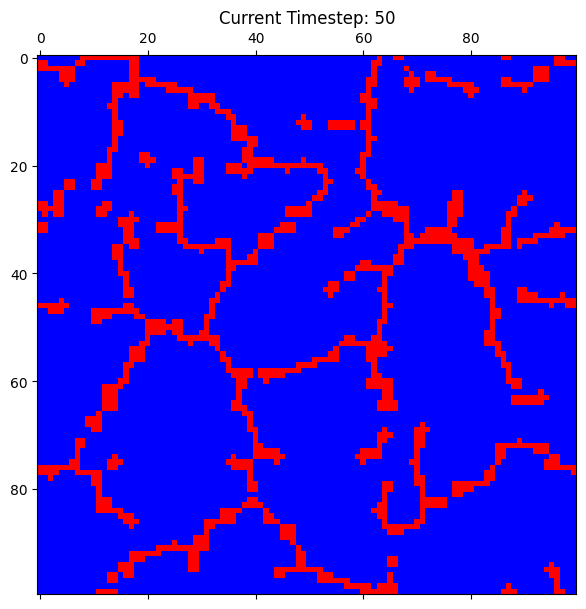

The total system utility is: 2267185.7800004124


In [62]:
# Run the model

import time
from IPython import display

defection_award = 1.59 # <--
total_runs = 50 # <--

# Counter for the total system utility
total_system_utility = 0

# Create the initial condition
initialize() # <-- Which function initializes the model?

# View the initial condition
current_run = -1
observe()
display.display(plt.gcf())
display.clear_output(wait=True) # clear the output here
time.sleep(0.5) # changing this number changes the speed of the visual updates

for current_run in range(total_runs):
  update() # <-- which function updates the model?
  plt.close()
  observe() # <-- which function allows us to observe our model using a visualization?

  # The lines of code below run the animation!
  display.clear_output(wait=True) # clear the output here
  display.display(plt.gcf())
  time.sleep(0.1) # changing this number changes the speed of the visual updates

plt.close()

print("The total system utility is:", total_system_utility) # Print the total utility of the entire system during this run

**2.H** (4 points) Run the model for 50 timesteps with a ```defection_award``` of 1.59. Does a clear majority decision arise over time? Does the model oscillate or settle to a fixed state? Is this what you would have expected to observe before running the model?
>Recall that a ```defection_award``` of 1.59 means defecting players get a utility payoff of 1.59 for every cooperative neighbor in their neighborhood. Cooperative players get a payoff of 1 for every cooperative neighbor in their neighborhood.

***Double click*** and write down your response here!

A clear majority decision with blue color cooperators arise over time. We observe that there are oscillations in the proportion of cooperators and defectors over time with blue color cooperators taking over the most of graph and red color defectors oscillating between each blue part.

Within the first 5 timestamps, the red takes over the almost whole graph. But the blue gradually expands and takes over most of the part later.

From the final visualization of the grid, we can see a clear majority of blue color cooperators (value 1). This indicates that over time, cooperation has become the dominant strategy among players, despite the temptation to defect being set at a utility of 1.59 for every cooperating neighbor.

The total system utility is: 1866308.7800002485, suggesting that the grid has a significant number of cooperators, as cooperation yields a utility of 1 per cooperative neighbor. The large scale of the utility indicates that many players are surrounded by other cooperators.

Before running the model, I would have expected defectors to eventually take over due to their higher payoff. But with only a slightly higher payoff of 1.59 vs 1, that is not enough for defectors to completely take over the population.

**2.I** (2 points) Without running the model, detail what would happen if the ```defection_award``` was 0. Why is this the case?

***Double click*** and write down your response here!

All players would cooperate and the model would stabilize with 100% cooperation. This occurs because with a defection_award of 0, there is no payoff for defecting. Since defecting yields no utility, players would have no incentive to switch from cooperation to defection.

**2.J** (4 points) Play around with different positive values of ```defection_award```. Is there a value that causes all players to cooperate over time? Is there a value that causes all players to defect? If so, specify the values that you found.

> *FOR GRADING PURPOSES, RETURN THE MODEL TO ITS DEFAULTS AFTER ANSWERING THIS QUESTION*. (return the value of ```defection_award``` to 1.59)

***Double click*** and write down your response here!


 If defection_award is set to a value between 0 and 0.875, defecting becomes less beneficial than cooperating since a defecting player receives less utility from each cooperating neighbor than they would if they cooperated themselves. Players will gradually transition to cooperation as they discover from their neighbors that it results in a better utility, creating a grid that all players collaborate.

 For all players to defect, defection_award would need to be sufficiently high. If defection_award is high enough that even when surrounded mostly by defectors, a single cooperator still provides a higher utility than mutual cooperation, then players will switch to defection over time. For example, if we set the defection_award to 2.0, all players would be defected.

**2.K** (Extra credit: 5 points) If you run the model with a ```defection_award``` between 0.875 and 1, you'll likely see a few isolated defectors in a sea of cooperators. However, for values just outside of this range, you'll observe unanimous cooperation. Using calculations of player and neighbor utilities, explain why we observe this strange result.

***Double click*** and write down your response here!

A defector surrounded by 8 cooperators will have a utility of 8 * 0.875 = 7 to 8 * 1 = 8 with a defection_award of 0.875 to 1. Since they each have seven other cooperating neighbors, each of those eight cooperating neighbors will only have a utility of seven or eight in the interim. Accordingly, the defector's utility is on par with or marginally greater than that of its cooperative neighbors, suggesting that they wouldn't change the strategy. If the defection award is less than 0.875, a defector would receive less than 7 (0.875 * 8) in utility since each cooperating neighbor contributes less than 1 utility due to the defection award being less than 1. Players are therefore incentivized to always move from defection to cooperation. If the defection award is greater than 1, a defector would receive more than 8 in utility (defection_award * 8). Regardless of the neighbors' status, defection offers a higher utility than collaboration, which encourages players to defect rather than cooperate.

### Problem 3: Hail to the Victors (7 points + 2 extra credit points)
In order to properly congratulate the winners of the game, we need to find them! That will involve looking through all of the players to find the players who earned the highest ```utility_total``` over the course of the game.

**3.A** (3 points) You'll recognize the code here as being very similar to the ```eval_next_decision()``` function from 2.C. Go ahead and complete it to find the winning players.

In [63]:
# Find the highest utility agent
winning_players = []
highest_utility = 0

# Iterate through all of the players (Player objects) in the player dictionary
for current_player in player_dict.values():
  player_utility = current_player.utility_total # Access the utility total of the current player

  if player_utility > highest_utility:
    # we found a new highest utility!
    highest_utility = player_utility # <-- store the value of the new highest utility
    # Update the winning_players list with new information
    winning_players.clear()
    winning_players.append(current_player)

  elif player_utility == highest_utility:
    # we found a tie: add this player to the list without clearing it
    winning_players.append(current_player) # <-- Add this player to the list of winners

# Now, analyze the strategy of the winning players
print("There were", len(winning_players), "winning players in this game.\n")
for winner in winning_players:
  print("This winning player had strategy:\n", winner.rounds_cooperated, "rounds cooperated,\n", winner.rounds_defected, "rounds defected,\n for a total utility of", winner.utility_total,"\n")

There were 9 winning players in this game.

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a total utility of 400.0 

This winning player had strategy:
 51 rounds cooperated,
 0 rounds defected,
 for a 

**3.B** (4 points) Run the model one more time with a ```defection_award``` of 1.59. Then, run the codeblock from 3.A. to find the winners. Based on your results, answer the following:
* What was the total utility of each winner?
* How many times did the winner cooperate? How many times did the winner defect?
* Pretend that you're a player, and you can choose whether to cooperate or defect in each round. Based on these findings, what would your strategy be in this game if you always wanted to win?

***Double click*** and write down your response here!

The total utility of each winner is 400. There are 51 rounds that the winner cooperate and 0 round that the winner defect. If I'm a player in this game and wanted to always win, a strategy based on these findings would be to always cooperate.

We observe that the winners in this run earned the maximum total utility without defecting, despite the fact that the defection award was set at a level that could incentivize defecting.

**3.C** (Extra credit: 2 points) In addition to congratulating the winners of the game, you want to shame the losers. Copy and paste the codeblock above, and modify it to find the losers of the game.

In [69]:
# <-- Your response to 3.B. goes here
losing_players = []
lowest_utility = float('inf')

for current_player in player_dict.values():
    player_utility = current_player.utility_total

    if player_utility < lowest_utility:
        lowest_utility = player_utility
        losing_players.clear()
        losing_players.append(current_player)
    elif player_utility == lowest_utility:
        losing_players.append(current_player)

print("There were", len(losing_players), "losing players in this game.\n")
for loser in losing_players:
  print("This losing player had strategy:\n", loser.rounds_cooperated, "rounds cooperated,\n", loser.rounds_defected, "rounds defected,\n for a total utility of", loser.utility_total,"\n")

There were 1 losing players in this game.

This losing player had strategy:
 1 rounds cooperated,
 50 rounds defected,
 for a total utility of 4.0 



### Problem 4: Iterative Prisoner's Dilemma Experiment (9 points)
Now, we'll do some formal analysis on this model, such as the kind you'll be expected to do on your final projects.

For this experiment, we want to observe how changing the value of ```defection_award``` (our input parameter, or independent variable) results in different outcomes (the quantities we're measuring, or the dependent variables).

Our experiment will have two dependent variables:

1.   The total utility of the entire grid after ```total_runs``` = 50 rounds; We'll call this quantity ```total_system_utility```. Specifically, this quantity is equal to the sum of all the player ```utility_total```s.
2.   The number of cooperators in the final round (round 50) of the game; We'll call this quantity ```final_round_numCooperators```.

First, we need to create a function that can run the model for whatever value of ```defection_award``` we input.
> Note that we're not interested in the visualization here because we only care about measuring our two dependent variables. Because of this, we don't need to run ```observe()``` or clear the output.

**4.A** (2 points) Using the instructions above, complete the ```run()``` function, which runs the model with a ```defection_award``` of ```input_defection_award```, and outputs our two dependent variables (```total_system_utility``` and ```final_round_numCooperators```).

In [71]:
# Run function, no visualization, return total_system_utility

def run(defection_award_input):
  global current_run, total_system_utility, defection_award

  defection_award = defection_award_input
  total_runs = 50

  # Counter for the total system utility, the model updates this value as it runs
  total_system_utility = 0

  # Create the initial condition
  initialize() # <--

  for current_run in range(total_runs):
    update()# <-- what function updates the game every round?

  # The number of cooperators (1) is equal to the sum of cells in the grid. This is because 0 doesn't contribute to the sum.
  final_round_numCooperators = np.sum(current_decision_grid)

  return (total_system_utility, final_round_numCooperators) # <-- We need the function to return our two dependent variables

Below is the ```myPlot()``` function, which creates a line graph of both ```total_system_utility``` and ```final_round_numCooperators``` as a function of ```defection_award```. In other words, ```defection_award``` will be on the x axis and the outputs ```total_system_utility``` and ```final_round_numCooperators``` will share the y axis.

> Note that this is different from the heat map that we used to visualize our parameter sweep in Lab 4, Problem 4. Here, a standard graph is a better tool because we're only varying one input parameter (```defection_award```).

The ```myPlot()``` function has been completed for you, so go ahead and run it!

In [73]:
def myPlot(x_axis, average_system_utilities, average_final_cooperator_totals):
  fig, ax1 = plt.subplots()

  # Plot the average_system_utilities
  color = 'tab:orange'
  ax1.set_xlabel('Defection Award Factor')
  ax1.set_ylabel('Total System Utility', color=color)
  ax1.plot(x_axis, average_system_utilities, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  # Plot the average_final_cooperators
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Last Round Number of Cooperators (out of ' + str(total_rows*total_columns) + ")", color=color)  # we already handled the x-label with ax1
  ax2.plot(x_axis, average_final_cooperator_totals, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  # Figure title
  fig.suptitle("Total System Utility vs. Defection Award")

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  display.clear_output(wait=True)

Below is the codeblock that conducts the experiment. Here's how our experiment will work:
* We'll run the model for 11 values of ```defection_award``` ranging from 0.8 to 1.8 in increments of 0.1.
* For each ```defection_award_input```, we'll run the model 5 times and average our results over those 5 trials. Recall that the average equals (sum of observations)/(number of trials).

Therefore, this experiment will require 11 × 5 = 55 distinct runs of the model. Similar to Lab 4, Problem 4, running the model this many times will cause the experiment to take a few minutes to complete.

**4.B** (2 points) Using the information above, complete the codeblock below, and run it to conduct the experiment! It will take a while. Then post a screenshot of the result in the text block below (embedded or cloud link).

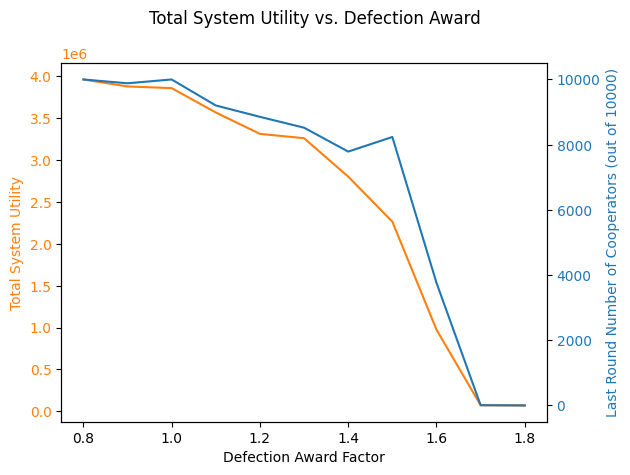

In [74]:
defection_award_sweep = [.8, .9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8] # <-- Independent variable, fill in the values of defection_award that we want to try
average_system_utilities = [] # Dependent variable #1, our code fills this up
average_final_cooperator_totals = [] # Dependent variable #2, our code fills this up

repetitions_per_value = 5 # <-- How many times do we run the model for each value of defection_award?

x_axis = [] # This list keeps track of the values on the x axis

for defection_award_input in defection_award_sweep: # <-- Loop through all of our defection_award_sweep values

  sum_reps_utility = 0 # This variable keeps track of the sum of utility over all 5 runs so we can calculate the average
  sum_reps_cooperators = 0 # This variable keeps track of the sum of final_round_numCooperators over all 5 runs so we can calculate the average

  for repetition in range(repetitions_per_value): # This loop runs all of the repetitions per value
    this_rep_utility, this_rep_cooperators = run(defection_award_input) # <-- What function runs the model for our input, and returns our dependent variables?
    sum_reps_utility += this_rep_utility # Increment the sum of total_system_utility outputs for this input
    sum_reps_cooperators += this_rep_cooperators # Increment the sum of final_round_numCooperators outputs for this input

  # Calculate the average result for this input by dividing the sum of observations by the number of trials
  average_utility = sum_reps_utility / repetitions_per_value
  average_final_cooperators = sum_reps_cooperators / repetitions_per_value # <--

  x_axis.append(defection_award_input) # Maintain the x-axis
  # Add the dependent variable outputs to lists so we can plot them
  average_system_utilities.append(average_utility)
  average_final_cooperator_totals.append(average_final_cooperators)

  # Plot the average system utilities for our different parameter values
  myPlot(x_axis, average_system_utilities, average_final_cooperator_totals)

***Double click*** and post the link to your screenshot here

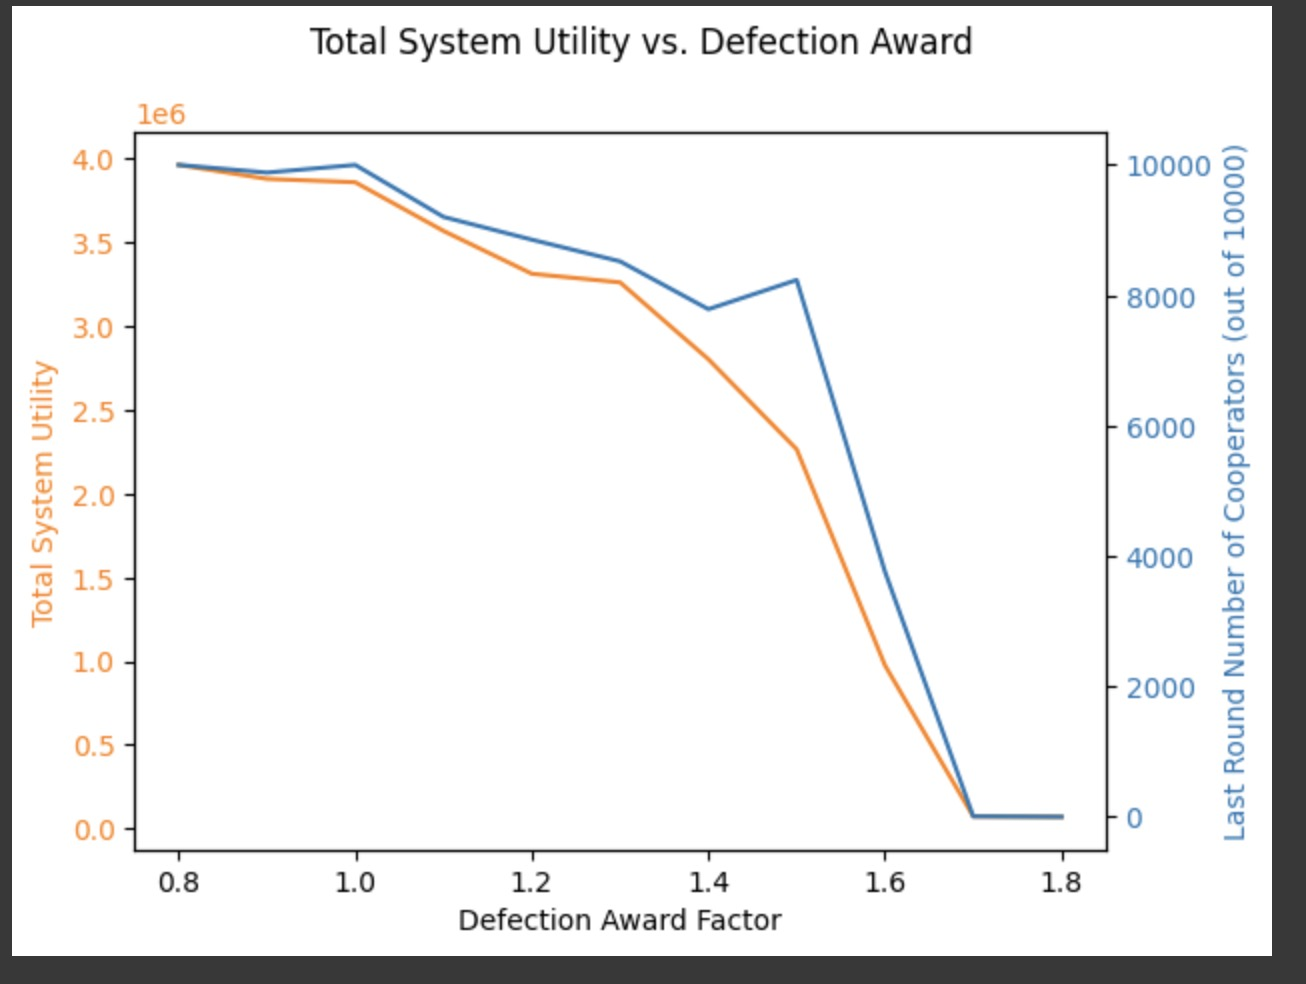

**4.C** (5 points) Interpret your results. As we increase the value of ```defection_award```, what happens in the model? How is the number of cooperators related to the total system utility?

***Double click*** and write down your response here!

As we increase the value of defection_award, the total system utility is decreasing. The number of cooperators in the last round also decreases as the defection_award increases. This suggests that as the defection_award increases, the benefit of defecting relative to cooperating increases. This incentivizes players to defect, leading to a decrease in the number of cooperators.

The total system utility relates closely to the number of remaining cooperators. Because the game is constructed such that cooperation benefits the group as a whole, the total system utility is highest when the defection_award is lowest. When defection_award is low, the incentive to defect is also low, resulting in more cooperation and a higher total system utility. As defection_award increases and the number of cooperators decreases, the total system utility also drops.

The peak total system utility (4.0 * 10^6) occurs when defection_award factor is equal to 0.8. The maximum last round number of cooperators (10000 out of 10000) also occurs when defection_award factor is equal to 0.8. When defection_award is so high (> 1.5) that there are less than 8000 cooperators, the total system utility drops substantially.

### Problem 5: We Live in a Society (10 points)
How might the Iterative Prisoner's Dilemma model help us to theorize about the emergence of cooperation and/or defection in society?
* List one aspect of real-world iteraction that the iterative prisoner's model captures well.
* List three aspects of real-world iteraction that this model fails to capture.
* Using this model, develop a theory about when you might expect to observe cooperation and defection, and what outcome is better for society as a whole.
* Come up with a specific, real world example to support your theory. You may use anecdotal evidence here if you wish.

***Double click*** and write down your response here!



The Iterative Prisoner's Dilemma model captures how people can adapt their cooperative and defective strategies based on behaviors on past experiences. If one side cooperates, the other is more inclined to cooperate in the future, which can lead to a stable partnership based on trust. This is consistent with observations made in the actual world, where people's decisions are frequently influenced by the benefits and costs of their actions.

There are several aspects of real-world interaction that this model fails to capture. Firstly, this model only includes two players in the game. However, the interactions in the real world often involve multiple parties with different relationships and power dynamics. This model does not account for the ability of individuals to negotiate and create legally enforceable contracts that can compel cooperation and discourage defection.
Moreover, real social networks have much more complex topologies than a grid as human networks might include clustering, preferential attachment, and some non-random patterns that influence how these strategies spread. There may be additional incentives and reasons that influence people's decisions, such as emotional outcomes and social norms. Besides, participants in this model are only able to recall one round prior to making a decision. However, in the real world, people have longer memories and their innate viewpoints shape their cooperative and competitive tendencies.


We might observe cooperation when future interactions can be reasonably expected. Then the long-term benefits of cooperation will outweigh the short-term gains from defection. Also when the payoffs for mutual cooperation are significantly higher than the payoffs for mutual defection, the cooperation is most likely to emergy. We might observe defection when the interaction is lack of trust or there is a history of negative relations between the parties. When the cost of being the sole cooperator is too high compared to the benefit of mutual cooperation, defection can be expected reasonably.
Cooperation tends to be better for society as a whole since it can lead to collectively optimal outcomes and prosperous communities.

A real-world example would be long-term business partnerships between companies. For example, suppose there are businesses that regularly follow procedures and work together with their partners to deliver high-quality products on schedule. This develops a reputation for reliability that can open up new business opportunities and contribute to long-term success. However, a business that defects by taking advantage of its partners (for example, providing inferior products) could benefit temporarily but would probably lose business as a result of its damaged reputation.
The Iterative Prisoner's Dilemma model helps theorize how businesses frequently take great care to avoid breaking agreements and why they spend money on quality control and customer service. They recognize that by cooperating, they all enjoy the benefits of business success and a favorable trading environment. Anecdotal evidence of this may be seen in a number of industries, including the technology sector, where sustained innovation and market stability depend on long-term partnerships and collaborations.